# Ajuste de T5 bajo WEBNLG

In [ ]:
# Número de GPUs y modelo
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ec9b2da7-3f53-04f1-b264-7c8ab59a2dbb)


In [ ]:
!nvidia-smi

Sun May 29 14:06:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   2344MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Instalación de las bibliotecas necesarias


En nuetro caso vamos a utilizar las bibliotecas Transformer de HuggingFace y SentencePiece para el tokenizador T5. 

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 6.6 MB 42.1 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.2 MB/s 
     |████████████████████████████████| 409 kB 53.5 MB/s 
     |████████████████████████████████| 140 kB 53.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |███████████████████████████████

A continuación importamos los módulos y bibliiotecas que utilizaremos durante el ajuste del modelo.

In [ ]:
import pandas as pd
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

## Carga de la base de datos WEBNLG



In [ ]:
train_df = pd.read_csv("Modelo T5 Final/Dataset/webNLG2020_train_cleaned.csv")
test_df = pd.read_csv("Modelo T5 Final/Dataset/webNLG2020_test_cleaned.csv")
test_train_df = pd.read_csv("Modelo T5 Final/Dataset/webNLG2020_testtrain_cleaned.csv")

Eliminamos la primera columna que indica la posición del ejemplo en el conjunto original ya que no nos va a hacer falta.

In [ ]:
train_df = train_df.drop(['Unnamed: 0'], axis=1)
test_df = test_df.drop(['Unnamed: 0'], axis=1)
test_train_df = test_train_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
train_df

,input_text,target_text
0,Acharya Institute of Technology | city | Banga...,The Acharya Institute of Technology in Karnata...
1,11th Mississippi Infantry Monument | country |...,The 11th Mississippi Infantry monument is loca...
2,A-Rosa Luna | ship displacement | 1850.0 (tonn...,The A-Rosa Luna was ordered on 22 January 2004...
3,United Kingdom | leader | Elizabeth II,Elizabeth II is the head of state in the Unite...
4,AIDAluna | owner | AIDA Cruises && AIDAluna | ...,AIDA Cruises own the AIDAluna which was built ...
...,...,...
35365,Blockbuster (comicsCharacter) | creator | Gard...,The comic book character Blockbuster was creat...
35366,Allama Iqbal International Airport | location ...,The Allama Iqbal International Airport is loca...
35367,Bacon Explosion | country | United States && U...,Bacon Explosion comes from the United States w...
35368,Turkey | leader | Ahmet Davutoğlu && Turkey | ...,"The capital of Turkey is Ankara , although the..."


Visualizamos brevemente el conjunto de datos y exploramos alguno de los ejemplos con la finalidad de comprender los datos que utilizaremos durante el entrenamiento y la evaluación del modelo.

In [ ]:
train_df.head()

,input_text,target_text
0,Acharya Institute of Technology | city | Banga...,The Acharya Institute of Technology in Karnata...
1,11th Mississippi Infantry Monument | country |...,The 11th Mississippi Infantry monument is loca...
2,A-Rosa Luna | ship displacement | 1850.0 (tonn...,The A-Rosa Luna was ordered on 22 January 2004...
3,United Kingdom | leader | Elizabeth II,Elizabeth II is the head of state in the Unite...
4,AIDAluna | owner | AIDA Cruises && AIDAluna | ...,AIDA Cruises own the AIDAluna which was built ...


In [ ]:
test_df.head()

,input_text,target_text
0,Super Capers | editing | Stacy Katzman && Supe...,['Both Michael Rooker and Tom Sizemore starred...
1,Expect a Miracle | runtime | 54.56 && Expect a...,['Expect a Miracle in the instrumental music g...
2,Olga Bondareva | birth date | 1937-04-27,"['Olga Bondareva was born on April 27 , 1937 ...."
3,Darinka Dentcheva | known for | Stochastic pro...,['Darinka Dentcheva is known for her work with...
4,The Fellowship of the Ring | followed by | The...,[ The Fellowship of the Ring was written by J ...


In [ ]:
test_train_df.head()

,input_text,target_text
0,Trane | product | Building Management System &...,['The Trane company is a subsidiary and it man...
1,Walter Baade | doctoral student | Allan Sandage,['Allan Sandage was a doctoral student of Walt...
2,"Tarrant County, Texas | county seat | Fort Wor...","['Arlington is part of the state of Texas , wh..."
3,Amatriciana sauce | region | Lazio && Amatrici...,['Pecorino Romano is an ingredient of Amatrici...
4,Ahmad Kadhim Assad | club | Esteghlal Ahvaz F....,[ Ahmad Kadhim Assad's club is Esteghlal Ahvaz...


In [ ]:
len(train_df)

35370

## Tokenización de los datos


En este apartado, tokenizamos los datos de entrada ya que haciendo uso del T5Tokenizer de la biblioteca Transformers. Este tokenizador es propio del modelo T5 y hace uso de SentencePiece para la codificación y decodificación de los datos.


A continuación, cargamos el tokenizador.

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Visualizamos el primer ejemplo del conjunto de datos con la finalidad de recordar como está compuesto.

In [ ]:
input_batch = train_df['input_text'][0]
input_batch

'Acharya Institute of Technology | city | Bangalore && Acharya Institute of Technology | established | 2000 && Acharya Institute of Technology | country |  India  && Acharya Institute of Technology | state | Karnataka && Acharya Institute of Technology | affiliation | Visvesvaraya Technological University'

A continuación, codifico este primer ejemplo del conjunto. Pruebo con  un max_length = 3 para comprobar el truncamiento correcto de datos.

In [ ]:
encoded = tokenizer.encode(input_batch, max_length=3,return_tensors='pt',truncation=True, add_special_tokens=True)
encoded

tensor([[14217,  1208,     1]])

In [ ]:
tokenizer.decode(encoded[0])

'Achary</s>'

En la prueba anterior podemos ver como únicamente ha tokenizado los primeros tres tokens del ejemplo.

A continuación, establecemos un límite de tokenización mucho mayor con la finalidad de que no corte la secuencia de entrada.

In [ ]:
input_batch = train_df['input_text'][0]
encoded = tokenizer.encode(input_batch, max_length=1024,return_tensors='pt',truncation=True)
encoded

tensor([[14217,  1208,     9,  2548,    13,  3669,  1820,   690,  1820, 23689,
             3,   184,   184, 14217,  1208,     9,  2548,    13,  3669,  1820,
          2127,  1820,  2766,     3,   184,   184, 14217,  1208,     9,  2548,
            13,  3669,  1820,   684,  1820,  1547,     3,   184,   184, 14217,
          1208,     9,  2548,    13,  3669,  1820,   538,  1820,  4556,    29,
           144,  5667,     3,   184,   184, 14217,  1208,     9,  2548,    13,
          3669,  1820, 24405,  1820, 13291,   162,     7,   900,  2866,     9,
         25789,  6207,   636,     1]])

In [ ]:
tokenizer.decode(encoded[0])

'Acharya Institute of Technology | city | Bangalore && Acharya Institute of Technology | established | 2000 && Acharya Institute of Technology | country | India && Acharya Institute of Technology | state | Karnataka && Acharya Institute of Technology | affiliation | Visvesvaraya Technological University</s>'

Como se comprueba anateriormente, el proceso de tokenización se compone de dos procesos inversos: codificación y decodificación. 

Tras la aplicación de ambos procesos de manera seguida se obtienen la misma secuencia de entrada por lo que el proceso de tokenización se realizó de manera correcta.

### Distribución de tokens

Es importante conocer el límite que podemos establecer al proceso de tokenización de los datos ya que durante el entrenamiento o ajuste deberán ser introducidos en lotes y cada uno de los ejemplos del lote deben tener la misma longitud sin truncamiento.

A continuación se realiza un estudio del número máximo de tokens del conjunto de datos, tanto de manera separada respecto a los datos de entrada y de destino, como conjunta.

In [ ]:
train_df_encoded = []
for _, example in train_df.iterrows():
  input_text = example['input_text']
  input_encoded = tokenizer.encode(input_text, padding=True, max_length=1024, return_tensors='pt', truncation=True)

  target_text = example['target_text']
  target_encoded = tokenizer.encode(target_text, padding=True, max_length=1024, return_tensors='pt', truncation=True)

  train_df_encoded.append((input_encoded,target_encoded))

In [ ]:
train_df_encoded[0]

(tensor([[14217,  1208,     9,  2548,    13,  3669,  1820,   690,  1820, 23689,
              3,   184,   184, 14217,  1208,     9,  2548,    13,  3669,  1820,
           2127,  1820,  2766,     3,   184,   184, 14217,  1208,     9,  2548,
             13,  3669,  1820,   684,  1820,  1547,     3,   184,   184, 14217,
           1208,     9,  2548,    13,  3669,  1820,   538,  1820,  4556,    29,
            144,  5667,     3,   184,   184, 14217,  1208,     9,  2548,    13,
           3669,  1820, 24405,  1820, 13291,   162,     7,   900,  2866,     9,
          25789,  6207,   636,     1]]),
 tensor([[   37, 14217,  1208,     9,  2548,    13,  3669,    16,  4556,    29,
            144,  5667,     3,     6, 23689,     3,     6,  1547,    47,  2127,
             16,  2766,     3,     5,    94,    19, 18273,    12,     8, 13291,
            162,     7,   900,  2866,     9, 25789,  6207,   636,     3,     5,
              1]]))

In [ ]:
lengths_inputs = []
lengths_target = []

for example in train_df_encoded:
  input_tokens = tokenizer.convert_ids_to_tokens(example[0][0])
  lengths_inputs.append(len(input_tokens))

  target_tokens = tokenizer.convert_ids_to_tokens(example[1][0])
  lengths_target.append(len(target_tokens))


Para visualizar la distribución de longitudes construimos unas gráficas que nos ayuden a realizar esta tarea.

In [ ]:
import matplotlib.pyplot as plt
from statistics import mean, stdev, variance
import numpy as np

In [ ]:
def showLenDistribution(all_lengths,max_linspace,steps):

  plt.hist(all_lengths, np.linspace(0, max_linspace, steps))
  plt.ylim(plt.ylim())
  max_length = max(all_lengths)
  plt.plot([max_length, max_length], plt.ylim())
  plt.title(f'Máximo número de tokens en un ejemplo: {max_length}');
  plt.show()

  print(f'          Media: {mean(all_lengths)}')
  print(f'          Desviación: {stdev(all_lengths)}')
  print(f'          Varianza: {variance(all_lengths)}')

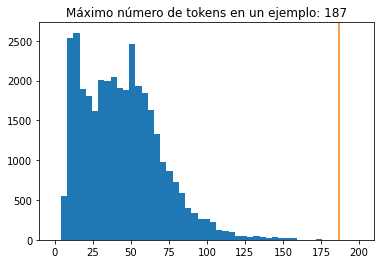

          Media: 44.33454905286966
          Desviación: 25.585019822295024
          Varianza: 654.5932393072293


In [ ]:
showLenDistribution(lengths_inputs, 200, 50)

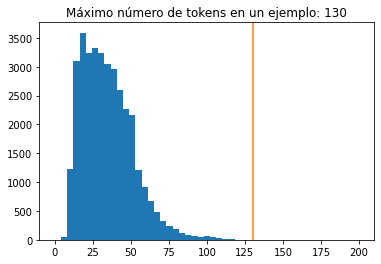

          Media: 34.794515125812836
          Desviación: 16.824764661862773
          Varianza: 283.0727059270663


In [ ]:
showLenDistribution(lengths_target, 200, 50)

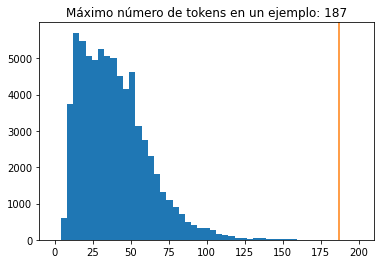

          Media: 39.56453208934125
          Desviación: 22.1715973365171
          Varianza: 491.5797284526521


In [ ]:
showLenDistribution([*lengths_inputs, *lengths_target], 200, 50)

In [ ]:
 # Establecemos el máximo número de tokens a un número ligeramente mayor al dado
MAX_TOKENS = 256

## Definicion del tokenizer y el modelo

In [ ]:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
model = model.to(dev)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

## Definición de hiperparámetros

In [ ]:
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=1

In [ ]:
num_of_batches=int(num_of_batches)

In [ ]:
optimizer = Adafactor(model.parameters(),lr=1e-3,
                      eps=(1e-30, 1e-3),
                      clip_threshold=1.0,
                      decay_rate=-0.8,
                      beta1=None,
                      weight_decay=0.0,
                      relative_step=False,
                      scale_parameter=False,
                      warmup_init=False)

## Creación del conjunto de datos para el entrenamiento

In [ ]:
from torch.utils.data import Dataset
from IPython.display import HTML, display
import ast

class WebNLG(Dataset):
  def __init__(self, dataset_df, tokenizer, bos_token, label_split):
    self.dataset_df = dataset_df
    self.tokenizer = tokenizer
    self.bos_token = bos_token    
    self.inputbatch = {'input_ids': [],'attention_mask':[]}
    self.targetbatch = {'input_ids': [],'attention_mask':[]}
    self.targetdecoded = []
    self.label_split = label_split
  
  def __len__(self):
    return len(self.dataset_df)
  
  def __getitem__(self, index):

    if isinstance(index, slice):
      input_ids   = self.inputbatch["input_ids"][index.start:index.stop]
      target_ids  = self.targetbatch["input_ids"][index.start:index.stop]

      if(self.label_split=="test"):
        return  {"input_ids": input_ids,  "target_ids": target_ids,"target_decode": self.targetdecoded[index.start:index.stop]}
      return {"input_ids": input_ids,  "target_ids": target_ids}

    elif isinstance(index, int):
      input_ids   = self.inputbatch["input_ids"][index]
      target_ids  = self.targetbatch["input_ids"][index]

      if(self.label_split=="test"):
        return  {"input_ids": input_ids,  "target_ids": target_ids,"target_decode": self.targetdecoded[index]}
      else:
        return  {"input_ids": input_ids,  "target_ids": target_ids}



  def build(self, num_of_batches, batch_size):

    out = display(self._progress(1, num_of_batches+1), display_id=True)
    

    for i in range(num_of_batches):
      inputbatch_aux=[]
      targetbatch_aux=[]
      if(self.label_split=="test"):self.targetdecoded.append([])
      subset_df = self.dataset_df[i*batch_size:i*batch_size+batch_size]

      for indx, row in subset_df.iterrows():
        input = self.bos_token + " " + row['input_text'] + "</s>"
        target = row['target_text'] + "</s>"
        inputbatch_aux.append(input)
        targetbatch_aux.append(target)

      # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          inputbatch_aux, padding=True, max_length = MAX_TOKENS, return_tensors='pt')

      # tokenize target
      if(self.label_split=="test"):
        tokenized_targets= {'input_ids':[]}
        for t in targetbatch_aux:
          t = ast.literal_eval(t[:-4])
          if(self.label_split=="test"):self.targetdecoded[-1].append([])
          for indx in range(len(t)):    
            if(self.label_split=="test"):
              t[indx] = t[indx] + " </s>"
              self.targetdecoded[-1][-1].append(t[indx])
            else:
              t[indx] = t[indx] + "</s>"
          tokenized_targets['input_ids'].append(self.tokenizer.batch_encode_plus(
              t,padding=True, max_length = MAX_TOKENS, return_tensors='pt')['input_ids'])

      else:
        tokenized_targets = self.tokenizer.batch_encode_plus(
              targetbatch_aux, padding=True, max_length = MAX_TOKENS, return_tensors='pt')

      self.inputbatch['input_ids'].append(tokenized_inputs['input_ids'])
      self.targetbatch['input_ids'].append(tokenized_targets['input_ids'])

      out.update(self._progress(i+1,num_of_batches+1))


  def _progress(self, value, max=100):
      return HTML(""" 
          <progress
              value='{value}'
              max='{max}',
              style='width: 100%'
          >
              {value}
          </progress>
      """.format(value=value, max=max))

In [ ]:
train_dataset = WebNLG(train_df, tokenizer,'WebNLG:', 'train')
train_dataset.build(num_of_batches, batch_size)

In [ ]:
test_dataset = WebNLG(test_df[:100], tokenizer,'WebNLG:', 'test')
test_dataset.build(int(100/batch_size), batch_size)

In [ ]:
testtrain_dataset = WebNLG(test_train_df[:100], tokenizer,'WebNLG:', 'test')
testtrain_dataset.build(int(100/batch_size), batch_size)

## Ajuste del modelo

In [ ]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

Para la evaluación

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def validate(dataset):

  bleu = []
  loss = []

  for batch in dataset:
    one_labels = []


    for l in batch['target_ids']:
      one_labels.append(list(l[0].numpy()))

    maxlen = max(len(i) for i in one_labels)

    for row in one_labels:
      if len(row) < maxlen:
          for k in range((maxlen - len(row))):
            row.extend([0])

    one_labels = torch.tensor(one_labels)
  
    # Calculo loss
    output = model(input_ids=batch['input_ids'].to(dev), labels = one_labels.to(dev))
    loss.append(output.loss.item())


    targets = model.generate(input_ids=batch['input_ids'].to(dev), num_beams=2, no_repeat_ngram_size=2)


    for label, target in zip(batch['target_decode'], targets):
      target = target.cpu().numpy()
      target = target[target != (1 and 0)]


      label_decoded =  [t.split() for t in label] 
      target_decoded = tokenizer.decode(target)   
      target_decoded =  target_decoded.replace('</s>',' </s>')
      target_decoded =  target_decoded.replace('.',' .')
      target_decoded =  target_decoded.replace(',',' ,')
      target_decoded =  target_decoded.replace('(','( ')
      target_decoded =  target_decoded.replace(')',' )')
      
      #calculare bleu score
      #print(f'label_decoded: {label_decoded}')
      #print(f'target_decoded: {target_decoded.split()}')
      bleu_score = sentence_bleu(label_decoded,target_decoded.split(),weights=(0.35, 0.3, 0.2, 0.15))
      #print(f'bleu: {bleu_score}')
      bleu.append(bleu_score)
      
  return bleu, loss

Para entrenar

In [ ]:
loss_per_steps_total = []
losstrain_per_steps = []
lossval_per_steps = []
bleuval_per_steps = []
bleutrain_per_steps = [] 

model.train()

for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)

  for i in range(num_of_batches):

    subset = train_dataset[i]

    inputbatch = subset['input_ids'].to(dev)
    labelbatch = subset['target_ids'].to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)

    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num

    if i%100 ==0:      
      loss_per_steps_total.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    if i % 500 ==0:

      
      model.eval()


      bleuval, lossval = validate(test_dataset)
      bleutrain, losstrain = validate(testtrain_dataset)

      
      bleuval_per_steps.append(sum(bleuval)/len(bleuval))
      print(f"Bleu media de val: {bleuval_per_steps[-1]}")
      bleutrain_per_steps.append(sum(bleutrain)/len(bleutrain))
      print(f"Bleu media de train: {bleutrain_per_steps[-1]}")

      lossval_per_steps.append(sum(lossval)/len(lossval))
      print(f"Loss media de val: {lossval_per_steps[-1]}")
      losstrain_per_steps.append(sum(losstrain)/len(losstrain))
      print(f"Loss media de train: {losstrain_per_steps[-1]}")
      print("____________________________________")
      
      model.train()

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()

  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch, running_loss))



Running epoch: 1


Bleu media de val: 0.0908222744991861
Bleu media de train: 0.1613274286569327
Loss media de val: 9.996417244275412
Loss media de train: 10.143216331799826
____________________________________
Bleu media de val: 0.317722170943374
Bleu media de train: 0.3279374398894605
Loss media de val: 0.7532945473988851
Loss media de train: 0.6385251606504122
____________________________________
Bleu media de val: 0.30760913612739643
Bleu media de train: 0.32146025997197897
Loss media de val: 0.7894082317749659
Loss media de train: 0.6859502196311951
____________________________________
Epoch: 1 , Running loss: 0.6063692831154142


In [ ]:
import pickle

with open('/content/drive/MyDrive/TFG/Sistema final/Modelos/Loss_model_10000.ob', 'wb') as fp:
    pickle.dump(loss_per_steps_total, fp)

with open('/content/drive/MyDrive/TFG/Sistema final/Modelos/Bleu_train_10000.ob', 'wb') as fp:
    pickle.dump(bleutrain_per_steps, fp)

with open('/content/drive/MyDrive/TFG/Sistema final/Modelos/Bleu_val_10000.ob', 'wb') as fp:
    pickle.dump(bleuval_per_steps, fp)

with open('/content/drive/MyDrive/TFG/Sistema final/Modelos/Loss_train_10000.ob', 'wb') as fp:
    pickle.dump(losstrain_per_steps, fp)

with open('/content/drive/MyDrive/TFG/Sistema final/Modelos/Loss_val_10000.ob', 'wb') as fp:
    pickle.dump(lossval_per_steps, fp)

## Testing the model

In [ ]:
model.save_pretrained("Modelo T5 Final/Modelos/webnlg/t5/t5_3epoch_30000examples")

In [ ]:
model.eval()
input_ids = tokenizer.encode("WenNLG: sidharth | hometown | Delhi && sidharth | play |  football </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
print(input_ids)
outputs = model.generate(input_ids)
tokenizer.decode(outputs[0])

tensor([[  101,    29, 18207,   517,    10,   108,    26,  3272,   189,  1820,
         22295,  1820, 10619,     3,   184,   184,   108,    26,  3272,   189,
          1820,   577,  1820,  3370,     1]], device='cuda:0')


'<pad> Sidharth, a football player, is from the city of Delhi'

















# Prueba

In [ ]:
model = model.from_pretrained("Modelo T5 Final/Modelos/webnlg/t5/t5_1epoch_30000examples")
model.to(dev)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: Mary | hometown | London && Mary | birthDate | 03-05-1950 </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids)
result = tokenizer.decode(outputs[0])
result

'<pad> Mary was born on 03/05/1950 in London.</s>'

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: David | occupation | football_player && David | first_club |FC_Bayern_Munich && David | started_playing | 2005 </s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids, max_length=100)
result = tokenizer.decode(outputs[0])
result

'<pad> David first played for FC Bayern_Munich in 2005 and is a football player.</s>'

In [ ]:
model.eval()
input_ids = tokenizer.encode("WebNLG: Mario | hobby | exercise && Mario | win | bodybuilding_awards</s>", return_tensors="pt")  # Batch size 1
input_ids=input_ids.to(dev)
outputs = model.generate(input_ids,max_length=100)
result = tokenizer.decode(outputs[0])
result

'<pad> Mario is a performer of the bodybuilding, he is a performer of exercise and won the title of the champion of the bodybuilding, awards.</s>'

In [ ]:
def to_sentence(sentence,model):
  model.eval()
  sentence2 = "WebNLG: " +sentence + " </s>"
  input_ids = tokenizer.encode(sentence2, return_tensors="pt")  # Batch size 1
  input_ids=input_ids.to(dev)
  outputs = model.generate(input_ids, num_beams=5, temperature=1.5, max_length=100)
  return tokenizer.decode(outputs[0])

In [ ]:
sentence = 'Mary | hometown | London, England && Mary | birthdate | 15-02-1950 && Mary | occupation | teacher'

result1 = to_sentence(sentence,model)

print(result1)

<pad> Mary was born on the 15th February, 1950 in London, England. She worked as a teacher.</s>


In [ ]:
data = []
data.append("Juan | occupation | labrador && Juan | was | alcoholic")
data.append("Mary | uncle | Olivia")
data.append("Mary | siblings | 14")

result = []
for sentence in data:
  text_en = to_sentence(sentence,model)
  result.append(text_en)
print(result)

['<pad> Juan, who served as a labrador, was alcoholic.</s>', "<pad> The uncle of Mary's uncle is Olivia.</s>", "<pad> Mary's siblings are 14.</s>"]


## Historia de vida completa

In [ ]:
def to_sentence(sentence,model,**args):
  model.eval()
  sentence2 = "WebNLG:" +sentence + "</s>"
  input_ids = tokenizer.encode(sentence2, return_tensors="pt")  # Batch size 1
  input_ids=input_ids.to(dev)
  outputs = model.generate(input_ids,**args)
  return tokenizer.decode(outputs[0])

In [ ]:
s00 = "Elisa | birth place | Lugo, Galicia && Elisa | birth date | 18-05-1937 && Elisa | age | 82 && Elisa | father’s name | Juan && Elisa | mother’s name | Eva"
s0 = "Juan | occupation | labrador && Juan | wife | Eva && Juan | birth place | Santander && Juan | birth date | 25-11-1911 && Eva | birth place | Barcelona && Eva | birth date | 12-01-1912 && Eva | occupation | seamstress"
s1 = "Juan | occupation | labrador && Juan | wife | Eva && Juan | birth place | Santander && Juan | birth date | 25-11-1911 && Eva | birth place | Barcelona && Eva | birth date | 12-01-1912 && Eva | occupation | seamstress"
s2 = "Elisa | educated at | La Salle's school && La Salle's school | was | all-girl catholic && Elisa | favorite school subjects | history && Elisa | favorite school subjects | drawing "
s3 = "Elisa | best friend | Veronica && Elisa | best friend | Luis && Elisa | played with | friends && Elisa | favorite games | hide-and-seek && Elisa | go swimming with | friends "
s4 = "Elisa'father | died | when Elisa was 13 years old && Elisa | help her mother | with housework "
s5 = "Elisa | drop out of school | when Elisa was 15 years old && Elisa | drop out of school | because of poverty "
s6 = "Elisa | worked at | workshop sewing && Elisa | liked | her work && Elisa | sewed | pretty dresses "
s7 = "Elisa | care | little brothers && Elisa | do | father's work && Elisa | prepare | bread every day && Elisa | bring bread | to customers "
s8 = "Elisa | educated at | Santiago's university && Elisa | career | education && Elisa | meet new friends | in her university classes && Elisa | best friend | Maria && Elisa | best friend | Laura "
s9 = "Elisa | started work | 20 years old && Elisa | worked in | textile factory && textile factory | location | Burgos "
s10 = "Elisa | like | festivals && Elisa | meet | Sergio && Sergio | ask Elisa | to dance && Elisa | fall in love with | Sergio && Elisa | started dating | Sergio "
s11 = "Elisa | bought a | shop in Santander && Elisa | set up a | sewing shop && Elisa | worked | hard "
s12 = "Elisa | marry | Sergio && Elisa | marry in | beautiful church in Santander && Elisa | had | 2 children && Elisa | son's name | Julio "

In [ ]:
s = [s00,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12]

In [ ]:
for sentence in s:
  print(to_sentence(sentence,model,do_sample = False, num_beams = 6, no_repeat_ngram_size = 4, num_beam_groups=3,
            min_length = 0, max_length = 75, top_k = 50, top_p = 0.92, temperature = 1,
            repetition_penalty = 1))

<pad> Elisa was born in Lugo, Galicia on May 17th, 18.05.1937. His father's name is Juan and his name is Eva.</s>
<pad> Born in Santander, on November 1911, Juan was married to Eva, who worked as a seamstress. He served as a labrador.</s>
<pad> Elisa was born in La Salle, a school that was all-girl catholic. Her favorite school subjects are the drawing and her school was La Salle's school.</s>
<pad> Veronica is the best friend of Elisa, who played with friends and her favorite games are hide-and-seek. Elisa's best friend is Luis.</s>
<pad> Elisa died in 13 years old. She was a houseworker.</s>
<pad> Elisa was 15 years old and died of poverty.</s>
<pad> Elisa worked at the workshop sewing and she was sewed in pretty dresses.</s>
<pad> Elisa, who has a father's work, is a little brother of Elisa who is a baker who serves to customers.</s>
<pad> Elisa was a student at the Santiago's university and was best friends with Laura. Elisa is a professional in the education field. She was born in

In [ ]:
print(to_sentence(
    "Elisa | birth place | Lugo, Galicia && Elisa | birth date | 18-05-1937 && Elisa | age | 82 && Elisa | father’s name | Juan && Elisa | mother’s name | Eva",
    model,do_sample = False, num_beams = 18, no_repeat_ngram_size = 7, num_beam_groups=3,
            min_length = 0, max_length = 150, top_k = 50, top_p = 0.92, temperature = 1.0,
            repetition_penalty = 1.0))

<pad> Elisa was born in Lugo, Galicia on May 1937. His father's name is Juan and his name is Eva.</s>


# Explicaciones de resultados

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 5.1 MB/s 
     |████████████████████████████████| 132 kB 50.4 MB/s 
     |████████████████████████████████| 8.8 MB 50.0 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 138 kB 57.6 MB/s 
     |████████████████████████████████| 127 kB 38.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from transformers import utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

In [ ]:
model_with_attention = model.from_pretrained("Modelo T5 Final/Modelos/webnlg/t5/t5_1epoch_30000examples",output_attentions=True)

In [ ]:
model_with_attention.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
model_with_attention.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
encoder_input_ids = tokenizer("WebNLG: Elisa | birth place | Lugo && Elisa | birth date | 18/05/1937 </s>", return_tensors="pt", add_special_tokens=True).input_ids
decoder_input_ids = tokenizer("Elisa was born in Lugo on May 1937. </s>", return_tensors="pt", add_special_tokens=True).input_ids
outputs = model_with_attention(input_ids=encoder_input_ids, labels=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])
tokens = tokenizer.convert_ids_to_tokens(encoder_input_ids[0]) 

In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text,
    include_heads=False,
    tokens = tokens,
    display_mode="light"
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from bertviz import head_view
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])  # Convert input ids to token strings
head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text,
    tokens = tokens
)


Output hidden; open in https://colab.research.google.com to view.